### Tips
- 仓位的单位是金额而不是份数
- 展期收益可以从两个角度来理解
    - 当你持有一个期货合约（而非现货）时，所获得的超额收益，就叫做展期收益。
    - 展期收益反映了换月时期货合约切换带来的额外收益或损失。

    无论怎么理解本质上都是当下的期货价格-现货价格，即当下的升贴水大小，在第两种语境下期货价格收敛于现货价格确保了这一结论的成立。
- IH 与 IF 为大盘蓝筹风格；IC 与 IM 为中盘成长风格


### 困惑
1. 理论上 P3 的表格中应该满足期货收益=指数收益+展期收益，但是实际却接近但不符合这一规律，如何理解。包括累计收益的计算。后续有做复现，不知道理解是否正确。
2. 市值因子是什么？如何计算的？为什么说会等资金配置会有很大的市值因子暴露。
3. P7为什么说品种间相关性较小时会导致 beta 风险对冲效果不佳。

# 1. 前提假设研究

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FZKai-Z03S']
mpl.rcParams['axes.unicode_minus'] = False
from config import *
from data_utils import *

| 代码     | 名称         | 对应指数         | 风格         | 对应ETF代码              |指数代码|
| ------ | ---------- | ------------ | ---------- | -------------------- | ----- |
| **IF** | 沪深300股指期货  | **沪深300指数**  | 大盘、主流蓝筹    | 510300.SH（华泰柏瑞沪深300） |000300.SH |
| **IH** | 上证50股指期货   | **上证50指数**   | 超大盘、金融地产   | 510050.SH（华夏上证50）    |000016.SH |
| **IC** | 中证500股指期货  | **中证500指数**  | 中盘成长、广义中小盘 | 510500.SH（南方中证500）   |000905.SH |
| **IM** | 中证1000股指期货 | **中证1000指数** | 小盘成长、弹性大   | 512100.SH（中证1000ETF） |000852.SH |


- 中证指数作为指数发布方，提供指数；
- 各 ETF 发行方（如华夏、华泰柏瑞、南方）复制跟踪该指数；
- 在不同交易所（沪深）挂钩的是“ETF”，不是指数本身。

✅ 指数值在不同市场是相同的；

✅ ETF价格可能不同，因其受交易供需、流动性、折溢价等影响。

1. 不同股指间本身有一定的相关性：根据折线图直观感受和相关系数矩阵结果可以表明确实四个产品之间具有比较高的相关性，但是根据投资组合理论对于相关性高的产品其实波动率降低能力有限，后续需观察这一现象是否在策略上有体现。
2. IH/IF 与 IC/IM 是相关性较高的两个配对：因为 IH 与 IF 都是大盘蓝筹风格，IC 与 IM 都是中小盘成长风格。

In [ ]:
#该部分可以用 pivot_index_data 替换
index_df=pd.read_csv(INDEX_DATA)
HS300_df=index_df[index_df['thscode']=='000300.SH']
ZZ500_df=index_df[index_df['thscode']=='000905.SH']
ZZ1000_df=index_df[index_df['thscode']=='000852.SH']
SZ50_df=index_df[index_df['thscode']=='000016.SH']
index_df = pd.DataFrame({
    '000300.SH': HS300_df['close'].reset_index(drop=True),
    '000905.SH': ZZ500_df['close'].reset_index(drop=True),
    '000852.SH': ZZ1000_df['close'].reset_index(drop=True),
    '000016.SH': SZ50_df['close'].reset_index(drop=True)
})

In [ ]:
# 重置index并创建新的DataFrame
corr_matrix = index_df.corr()
print(corr_matrix)

3. 不同品种间的升贴水有很大差异，基差可能贡献大部分跨品种组合的收益（这一观点由收益分解结果支持）：本文所提到的这种升贴水差异主要体现在 futures_data 文件的 ICIF、IFIH、IMIC、IMIH 的数值上，这表示的是年化基差率的差异，权重是基于本金计算的。
- 理论基础：跨品种套利组合的总收益分解【这一现实情况决定了在进行策略信号构建时需要考虑分开预测大小盘风格于展期收益】
    - 指数相对涨跌的收益（style effect，风格轮动）：不同风格（如大盘 vs 小盘、价值 vs 成长）在不同时期表现交替领先或落后，从而形成了可以利用的轮动机会。
    - 展期收益（基差收敛带来的收益）：当你持有一个期货合约（而非现货）时，所获得的超额收益，就叫做展期收益，具体来说比如你持有的是期货合约而不是现货，额外多赚了 50 点，这部分就叫展期收益。展期收益 = 期货价格变动 – 现货价格变动，$展期收益=（F_t^{平仓}-F_0^{建仓}）-（S_t-S_0）$，由于平仓期货价格收敛于现货价格，所以展期收益本质上就是基差，即升贴水的值。

【份数相同情景】组合总收益=
$(F_A^{t_1}-F_A^{t_0})-(F_B^{t_1}-F_B^{t_0})=$

$(S_A^{t_1}+基差_A^{t_1}-S_A^{t_0}-基差_A^{t_0})-(S_B^{t_1}+基差_B^{t_1}-S_B^{t_0}-基差_B^{t_0})=$

$(S_A^{t_1}-S_A^{t_0})-(S_B^{t_1}-S_B^{t_0})+(基差_A^{t_1}-基差_A^{t_0})-(基差_B^{t_1}-基差_B^{t_0})=$

$\Delta S_A-\Delta S_B+(基差_A^{t_1}-基差_B^{t_1})-(基差_A^{t_0}-基差_B^{t_0})$

- 结论：
1. 在实操的时候构建信号将「风格轮动预测」和「基差与指数信号」分开考虑，而后合成为跨品种套利的策略信号。
    1. 风格轮动对应的是$\Delta S_A-\Delta S_B$部分
    2. 如果持有至接近期限，那么$(基差_A^{t_1}-基差_B^{t_1})$会很接近于 0，此时问题的关键在于建仓时的基差的差额
2. 因为 IH/IF 与 IC/IM 是两个相关性较高的配对，所以策略也可以被分为同风格的跨品种套利和跨风格的跨品种套利。
3. 当金额相同时基差的差转为了基差率的差

In [ ]:
futures_data=pd.read_csv(FUTURES_DATA)
futures_df = pd.DataFrame({
    'ICIF': futures_data['ICIF'],
    'IFIH': futures_data['IFIH'],
    'IMIC': futures_data['IMIC'],
    'IMIH': futures_data['IMIH']
})
futures_df.index = futures_data['time']

4. 四个品种的跨品种套利可以有两种基本思路：时间序列和横截面
    1. 时间序列的含义是确定组合方式（视作一个资产比如 ICIF ），策略核心在于通过因子择时买入和卖出
    2. 横截面思路是组合方式不确定，但是策略持有期固定（未必，待补充），策略核心在于通过因子确定各资产买入权重。

5. 主力合约的收益分解

In [ ]:
index_df=pd.read_csv(INDEX_DATA)
index_pivot_df=pivot_index_data(index_df,CODE_MAP)
futures_df=pd.read_csv(FUTURES_DATA)
futures_df['time'] = pd.to_datetime(futures_df['time'])
futures_df['IC_LTDATE_NEW']=pd.to_datetime(futures_df['IC_LTDATE_NEW'])
futures_df['IF_LTDATE_NEW']=pd.to_datetime(futures_df['IF_LTDATE_NEW'])
futures_df['IH_LTDATE_NEW']=pd.to_datetime(futures_df['IH_LTDATE_NEW'])
futures_df['IM_LTDATE_NEW']=pd.to_datetime(futures_df['IM_LTDATE_NEW'])
total_df= pd.merge(futures_df, index_pivot_df, on='time', how='left')
IFIH_df = pd.DataFrame({
    'time': total_df['time'],
    'index_return': total_df['IF_udy_changeRatio']-total_df['IH_udy_changeRatio'],
    'futures_return': total_df['IF_PCT_CHG']-total_df['IH_PCT_CHG'],
    'basis_return': total_df['IFIH']/244
})
IFIH_df['index_nv']=(1+IFIH_df['index_return']).cumprod()
IFIH_df['futures_nv']=(1+IFIH_df['futures_return']).cumprod()
IFIH_df['basis_nv']=(1+IFIH_df['basis_return']).cumprod()

# 2. 根据基差构建夸品种套利信号
## 2.1 时序思路
- 思路：等资金做多一个品种并做空一个品种，根据主力合约年化基差率之差构建跨品种套利仓位信号（具体来说计算差值后取相反数*10）
- 起源：跨品种期货收益分解公式，根据公式可知在其他条件不变的情况下，基差率之差越大，收益越大，所以基差率差的大小可以作为一种仓位信号。

## 2.2 基于波动率中性改进的时序思路
- 思路：等资金的一个隐患是有较大的市值风险因子暴露

- 所以说整个代码逻辑其实很简单，中间过程是怎么样的无所谓，最终就是要搞明白生成的交易信号是什么？交易信号对应的交易逻辑是什么就可以了！b

# 基差收敛特征检验

In [5]:
from config import FUTURES_DATA

# basis_convergence_analysis.py
# 针对股指期货跨品种多空组合的基差收敛性检验 (基于已提供的CSV结构)
# 输入：单个 CSV 包含日期和各品种年化基差、开盘价、日涨跌幅列等基础数据
# 参数：pair，如 'IMIH'，表示多 IM 空 IH
# 支持：ADF 单根检验、分位检验、OLS 回归检验、未来 N 日累计收益计算

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


def load_data(
    csv_file: str,
    date_col: str = 'date'
) -> pd.DataFrame:
    """
    读取 CSV 并解析日期，返回原始 DataFrame
    要求列包含：
      * {sym}_ANAL_BASISANNUALYIELD for sym in ['IF','IC','IH','IM']
      * {sym}_PCT_CHG for sym in ['IF','IC','IH','IM']
    """
    df = pd.read_csv(csv_file)
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.sort_values(date_col).reset_index(drop=True)
    return df


def compute_pair_series(
    df: pd.DataFrame,
    pair: str,
    date_col: str = 'date'
) -> pd.DataFrame:
    """
    根据 pair 参数（如 'IMIH'）生成组合:
      basis_diff = IM_ANAL_BASISANNUALYIELD - IH_ANAL_BASISANNUALYIELD
      pair_return = IM_PCT_CHG - IH_PCT_CHG
    返回含 ['date','basis_diff','pair_return'] 的 DataFrame
    """
    # 提取多空品种标识
    sym_long = pair[:2]
    sym_short = pair[2:]
    # 对应列名
    basis_long_col = f"{sym_long}_ANAL_BASISANNUALYIELD"
    basis_short_col = f"{sym_short}_ANAL_BASISANNUALYIELD"
    ret_long_col = f"{sym_long}_PCT_CHG"
    ret_short_col = f"{sym_short}_PCT_CHG"
    # 检查列是否存在
    for col in [basis_long_col, basis_short_col, ret_long_col, ret_short_col]:
        if col not in df.columns:
            raise ValueError(f"缺少列 {col}，请检查CSV结构。")
    # 构建结果
    out = pd.DataFrame({
        date_col: df[date_col],
        'basis_diff': df[basis_long_col] - df[basis_short_col],
        'pair_return': df[ret_long_col] - df[ret_short_col]
    })
    return out


def compute_forward_return(
    df: pd.DataFrame,
    ret_col: str = 'pair_return',
    days: int = 5,
    date_col: str = 'date'
) -> pd.DataFrame:
    """
    计算未来 N 日累计收益：
      fwd_{days}d = product(1 + ret_{t+1} ... ret_{t+days}) - 1
    """
    df = df.sort_values(date_col).reset_index(drop=True)
    rets = df[ret_col].fillna(0).values
    fwd = []
    for i in range(len(df)):
        if i + days < len(df):
            cum = np.prod(1 + rets[i+1:i+days+1]) - 1
        else:
            cum = np.nan
        fwd.append(cum)
    df[f'fwd_{days}d'] = fwd
    return df


def adf_test(
    series: pd.Series,
    **kwargs
) -> dict:
    """
    对序列做 ADF 单根检验，返回统计量、p值及关键值
    """
    result = adfuller(series.dropna(), **kwargs)
    return {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Observations': result[3],
        'Critical Values': result[4]
    }


def quantile_test(
    df: pd.DataFrame,
    basis_col: str = 'basis_diff',
    fwd_col: str = 'fwd_5d',
    n: int = 5
) -> pd.DataFrame:
    """
    将 basis_diff 分 n 组，比较各组未来累计收益
    """
    tmp = df.dropna(subset=[basis_col, fwd_col]).copy()
    tmp['quantile'] = pd.qcut(tmp[basis_col], n, labels=False)
    stats = tmp.groupby('quantile')[fwd_col].agg(['mean','std','count'])
    print("=== Quantile Test ===")
    print(stats)
    return stats


def regression_test(
    df: pd.DataFrame,
    basis_col: str = 'basis_diff',
    fwd_col: str = 'fwd_5d'
) -> sm.regression.linear_model.RegressionResultsWrapper:
    """
    执行 OLS 回归：fwd ~ basis_diff
    """
    data = df.dropna(subset=[basis_col, fwd_col])
    X = sm.add_constant(data[basis_col])
    y = data[fwd_col]
    model = sm.OLS(y, X).fit()
    print("=== Regression Test ===")
    print(model.summary())
    return model

In [8]:
# 用户配置
CSV_FILE = FUTURES_DATA  # 请替换为你的 CSV 文件路径
PAIR = 'ICIF'                  # 可选：'IFIH','ICIF','IMIC','IMIH'
DAYS = 5                       # 未来 N 日累计收益
QUANTILES = 5                  # 分位数

# 加载数据
df_all = load_data(CSV_FILE)
# 构建组合序列
df_pair = compute_pair_series(df_all, PAIR)
# 计算前瞻收益
df_pair = compute_forward_return(df_pair, days=DAYS)

# ADF 检验
adf_res = adf_test(df_pair['basis_diff'])
print(f"=== ADF Test on Basis Diff for {PAIR} ===")
for k, v in adf_res.items(): print(f"{k}: {v}")

# 分位检验
quant_stats = quantile_test(
    df_pair,
    basis_col='basis_diff',
    fwd_col=f'fwd_{DAYS}d',
    n=QUANTILES
)

# 回归检验
model = regression_test(
    df_pair,
    basis_col='basis_diff',
    fwd_col=f'fwd_{DAYS}d'
)

# 可视化或保存结果可按需添加


=== ADF Test on Basis Diff for ICIF ===
Test Statistic: -2.5504793516141095
p-value: 0.10367007816862411
Lags Used: 12
Observations: 355
Critical Values: {'1%': np.float64(-3.448905534655263), '5%': np.float64(-2.8697161816205705), '10%': np.float64(-2.5711258103550882)}
=== Quantile Test ===
              mean       std  count
quantile                           
0        -0.002196  0.022505     73
1         0.001149  0.011090     72
2         0.002957  0.014225     73
3         0.001626  0.017061     72
4        -0.007116  0.015449     73
=== Regression Test ===
                            OLS Regression Results                            
Dep. Variable:                 fwd_5d   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     8.577
Date:                Fri, 01 Aug 2025   Prob (F-statistic):            0.00362
Time:                        11:22:

In [19]:
futures_data = pd.read_csv(FUTURES_DATA)
futures_data['date'] = pd.to_datetime(futures_data['date'])
futures_data.set_index('date', inplace=True)

symbols = ["IC","IH","IM","IF"]
for symbol in symbols:
    pct_chg_col = f"{symbol}_PCT_CHG"
    vol_col = f"{symbol}_vol"
    futures_data[vol_col] = futures_data[pct_chg_col].rolling(window=60).std()

futures_data = futures_data.dropna()

inv = {sym:1/futures_data[f'{sym}_vol'] for sym in symbols}
inv_df = pd.DataFrame(inv)

norm_inv = inv_df.div(inv_df.sum(axis=1), axis=0)

for symbol in symbols:
    yr_basis_col = f'{symbol}_ANAL_BASISANNUALYIELD'
    futures_data[f'{symbol}_adjusted_yrbasis'] = norm_inv[symbol] * futures_data[yr_basis_col]

yrb_cols = [f'{sym}_ANAL_BASISANNUALYIELD' for sym in symbols]
open_cols = [f'{sym}_OPEN' for sym in symbols]
adj_cols = [f'{sym}_adjusted_yrbasis' for sym in symbols]

futures_data.reset_index(inplace=True)
# 为每个 symbol 生成一张小表，然后 concat
frames = []
for sym in symbols:
    tmp = futures_data[['date',
            f'{sym}_OPEN',
            f'{sym}_ANAL_BASISANNUALYIELD',
            f'{sym}_adjusted_yrbasis']].copy()
    tmp['symbol'] = sym
    tmp = tmp.rename(columns={
        f'{sym}_OPEN':                'open',
        f'{sym}_ANAL_BASISANNUALYIELD':'yrbasis',
        f'{sym}_adjusted_yrbasis':    'adjusted_yrbasis'
    })
    frames.append(tmp)

df_final = pd.concat(frames, ignore_index=True)

# 重排一下列顺序
df_final = df_final[['date','symbol','open','yrbasis','adjusted_yrbasis']]

# 数据临时处理

In [1]:
#参数设定
import os
import pandas as pd
CODE_MAP = {
    '000852.SH': 'IM',  # 中证1000指数 -> IM期货
    '000905.SH': 'IC',  # 中证500指数 -> IC期货
    '000300.SH': 'IF',  # 沪深300指数 -> IF期货
    '000016.SH': 'IH',  # 上证50指数 -> IH期货
}
PROJECT_PATH = "/Users/yaoyuyang/Desktop/Code/daily_futures_arbitrary_strategy/src"
DATA_PATH = os.path.abspath(os.path.join(PROJECT_PATH, "..",'data'))
RAW_DATA_PATH=os.path.join(DATA_PATH, 'raw')
FILES = {
    '000852.SH':'000852.csv',
    '000905.SH':'000905.csv',
    '000300.SH':'000300.csv',
    '000016.SH':'000016.csv'
}
CAL_TYPE = "udy"
PAIRS = [('IM','IC'), ('IM','IF'), ('IM','IH'),
        ('IC','IF'), ('IC','IH'),
        ('IF','IH')]

                 date  IMIC_udy  IMIF_udy  IMIH_udy  ICIF_udy  ICIH_udy  \
0 2014-10-17 09:30:00  1.000000  1.000000  1.000000  1.000000  1.000000   
1 2014-10-17 09:31:00  0.999826  0.999047  1.000178  0.999221  1.000352   
2 2014-10-17 09:32:00  0.999484  0.999277  1.000185  0.999793  1.000701   
3 2014-10-17 09:33:00  0.999749  0.999990  1.001319  1.000240  1.001570   
4 2014-10-17 09:34:00  0.999913  1.000923  1.002706  1.001011  1.002794   
5 2014-10-17 09:35:00  1.000348  1.001220  1.002997  1.000872  1.002648   
6 2014-10-17 09:36:00  1.000574  1.001699  1.003678  1.001125  1.003103   
7 2014-10-17 09:37:00  1.000857  1.001458  1.002993  1.000601  1.002135   
8 2014-10-17 09:38:00  1.001008  1.000967  1.002342  0.999959  1.001333   
9 2014-10-17 09:39:00  1.000889  0.998798  0.999524  0.997911  0.998636   

   IFIH_udy  
0  1.000000  
1  1.001131  
2  1.000908  
3  1.001328  
4  1.001781  
5  1.001774  
6  1.001975  
7  1.001532  
8  1.001374  
9  1.000728  


In [2]:
#分钟级调仓
frames = []
for code, fname in FILES.items():
    path = os.path.join(RAW_DATA_PATH, fname)
    df = pd.read_csv(path)

    # 基本检查
    needed = {'time','thscode','close','pct_change'}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"{fname} 缺少列: {missing}")

    # 规范时间、排序
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time')

    ticker = CODE_MAP[code]  # IM/IC/IF/IH
    df = df[['time','pct_change']].rename(columns={'pct_change': f'r_{ticker}'})
    frames.append(df)

# ===== 合并：基于 time 内连接（题设称 time 完全一致，这里仍做 inner 以确保对齐）=====
merged = frames[0]
for d in frames[1:]:
    merged = merged.merge(d, on='time', how='inner')

# ===== 计算6个组合的累计净值并首日归一 =====
out = pd.DataFrame()
out['date'] = merged['time']

for long_t, short_t in PAIRS:
    diff = merged[f'r_{long_t}'] - merged[f'r_{short_t}']     # r_long - r_short
    cum_nv = (1.0 + diff).cumprod()
    series = cum_nv / cum_nv.iloc[0]
    col_name = f"{long_t}{short_t}_{CAL_TYPE}"                # 例如 IMIC_udy
    out[col_name] = series.values

# ===== 按要求的列顺序导出 =====
ordered_cols = ['date', 'IMIC_udy', 'IMIF_udy', 'IMIH_udy', 'ICIF_udy', 'ICIH_udy', 'IFIH_udy']
out = out[ordered_cols]

print(out.head(10))

已写出日频OHLC： pair_udy_ohlc.csv
        date  IMIC_open  IMIC_high  IMIC_low  IMIC_close  IMIF_open  \
0 2014-10-17   1.000000   1.001008  0.996008    0.997040   1.000000   
1 2014-10-20   0.996094   0.998945  0.996092    0.998750   0.989665   
2 2014-10-21   0.998492   1.000017  0.998054    0.999540   1.001370   
3 2014-10-22   0.999965   1.001184  0.999124    0.999124   1.000690   
4 2014-10-23   0.998366   0.998781  0.996485    0.997589   0.993431   
5 2014-10-24   0.997214   0.997980  0.995283    0.995443   0.987516   
6 2014-10-27   0.995501   0.999155  0.995002    0.999024   0.995356   
7 2014-10-28   0.999404   1.002842  0.999404    1.001081   1.013083   
8 2014-10-29   1.000847   1.004884  1.000847    1.000985   1.017896   
9 2014-10-30   1.001827   1.002288  0.999978    0.999987   1.018102   

   IMIF_high  IMIF_low  IMIF_close  IMIH_open  ...  ICIF_low  ICIF_close  \
0   1.001699  0.983100    0.990739   1.000000  ...  0.987042    0.993682   
1   1.001081  0.989665    1.001081   

In [ ]:
# ===== 将信号按天聚合为OHLC（开=每日首值，高=每日最大，低=每日最小，收=每日末值）=====
agg_dict = {}
for pair in ['IMIC', 'IMIF', 'IMIH', 'ICIF', 'ICIH', 'IFIH']:
    col = f"{pair}_udy"
    agg_dict[col] = ['first', 'max', 'min', 'last']

# 按 date 分组聚合
daily = out.groupby(out['date'].dt.floor('D')).agg(agg_dict)
daily.index.name = 'date'
# 扁平化列名 -> 例如 ("IMIC_udy", "first") -> "IMIC_open"
name_map = {'first': 'open', 'max': 'high', 'min': 'low', 'last': 'close'}
daily.columns = [f"{col.replace('_udy','')}_{name_map[fn]}" for col, fn in daily.columns]

daily = daily.reset_index()

# 按指定顺序排列列名（共25列）
ordered_daily_cols = [
    'date',
    'IMIC_open','IMIC_high','IMIC_low','IMIC_close',
    'IMIF_open','IMIF_high','IMIF_low','IMIF_close',
    'IMIH_open','IMIH_high','IMIH_low','IMIH_close',
    'ICIF_open','ICIF_high','ICIF_low','ICIF_close',
    'ICIH_open','ICIH_high','ICIH_low','ICIH_close',
    'IFIH_open','IFIH_high','IFIH_low','IFIH_close'
]

# 只保留上面定义的列顺序（若某列缺失会抛错，便于及早发现问题）
daily = daily[ordered_daily_cols]

# 输出新的日频OHLC表
DAILY_OHLC_CSV = "pair_udy_ohlc.csv"
daily.to_csv(DAILY_OHLC_CSV, index=False)
print("已写出日频OHLC：", DAILY_OHLC_CSV)
print(daily.head(10))

# 多策略综合配置研究

In [2]:
from data_utils import *
combined_df = get_concat_nv_data()

In [10]:
df_corr = combined_df.drop(columns=['date']).corr()

In [11]:
combined_return_df = combined_df.drop(columns=['date']).pct_change()
combined_return_df['date']=combined_df['date']
combined_return_df=combined_return_df.dropna()

In [13]:
df_return_corr = combined_return_df.drop(columns=['date']).corr()

In [15]:
test_a = combined_return_df.drop(columns=['IMIF_nv','IMIH_nv'])
test_a_corr = test_a.drop(columns=['date']).corr()

In [17]:
test_b = test_a.drop(columns = ['ICIH_nv'])
test_b_corr = test_b.drop(columns=['date']).corr()

In [18]:
test_c = test_a.drop(columns = ['ICIF_nv'])
test_c_corr = test_c.drop(columns=['date']).corr()

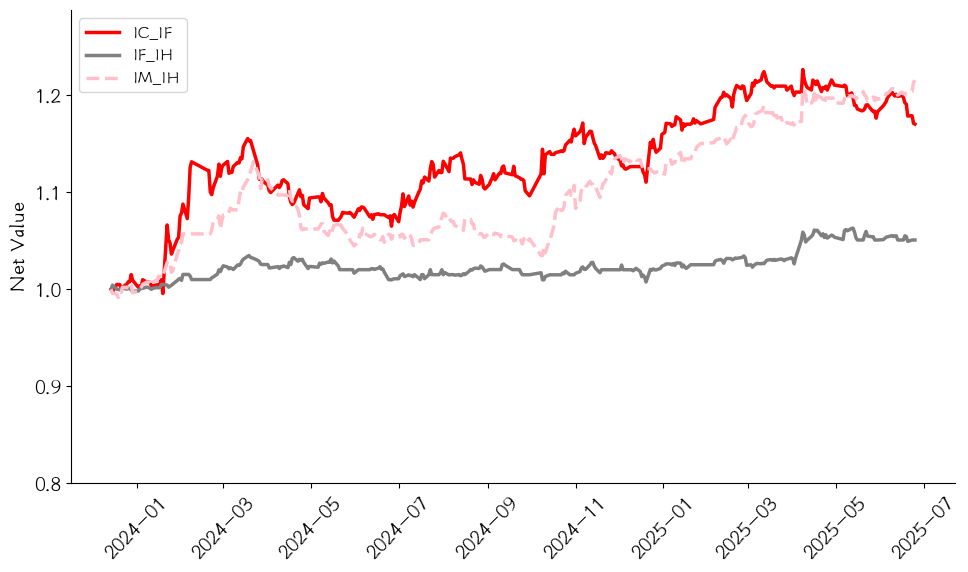

In [21]:
import matplotlib.pyplot as plt
import matplotlib
# plt.rcParams['font.sans-serif'] = ['simsun']  # 中文字体
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FZKai-Z03S']
mpl.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams.update({'font.size': 16})

In [23]:
plot_df = combined_df[['date','IMIC_nv','ICIF_nv','IFIH_nv']].copy()
plot_df['date'] = pd.to_datetime(plot_df['date'])
plt.figure(figsize=(10,6))

plt.plot(plot_df['date'],plot_df['ICIF_nv'],label = 'IC_IF',color = 'red',linewidth = 2.5)
plt.plot(plot_df['date'],plot_df['IFIH_nv'],label = 'IF_IH',color = 'gray',linewidth = 2.5)
plt.plot(plot_df['date'],plot_df['IMIC_nv'],label = 'IM_IH',color = 'pink',linewidth = 2.5,linestyle = '--')

plt.legend(loc='upper left',fontsize=12)
# 坐标轴与样式
plt.ylim(0.8, plot_df[['IMIC_nv','ICIF_nv','IFIH_nv']].max().max()*1.05)
plt.xticks(rotation=45)
plt.grid(False)
# 去掉顶部和右边边框
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# 设置标题和坐标轴
plt.ylabel('Net Value')
plt.tight_layout()
plt.show()

In [29]:
IMIC_std = test_b['IMIC_nv'].std()
ICIF_std = test_b['ICIF_nv'].std()
IFIH_std = test_b['IFIH_nv'].std()

np.float64(0.040641949754279816)

In [ ]:
import numpy as np
IFIH_std*np.sqrt(244)

## 策略复现

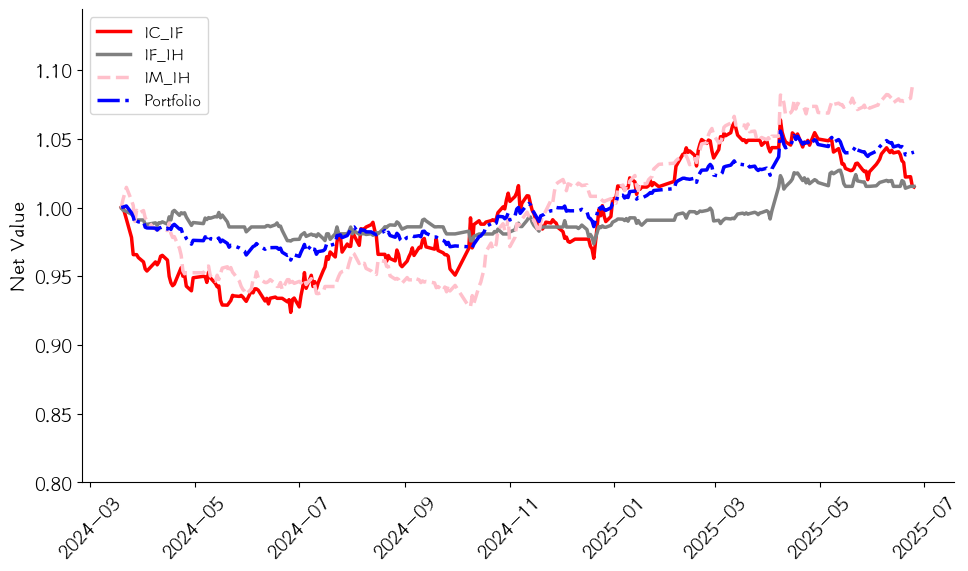

In [50]:
from data_utils import *
combined_df = get_concat_nv_data()
backtest_df = combined_df[['date','IMIC_nv','ICIF_nv','IFIH_nv']].copy()
backtest_df.set_index("date",inplace = True)
nv_cols = [c for c in backtest_df.columns if c.endswith('_nv')]
ret = backtest_df[nv_cols].pct_change()
vol = ret.rolling(window=60).std()
inv_vol = 1/vol
weights = inv_vol.div(inv_vol.sum(axis=1),axis=0)
# 为避免未来函数（look-ahead），所有权重往后移一格
weights = weights.shift(1).dropna()
port_ret = (weights * ret.loc[weights.index]).sum(axis=1)
backtest_df['portfolio_nv'] = (1 + port_ret).cumprod()
backtest_df.dropna(subset=['portfolio_nv'], inplace=True)
backtest_df = backtest_df.div(backtest_df.iloc[0])


In [55]:
plot_df = backtest_df.copy().reset_index()
plot_df['date'] = pd.to_datetime(plot_df['date'])

plt.figure(figsize=(10,6))

# 各策略净值曲线
plt.plot(plot_df['date'], plot_df['ICIF_nv'], label='IC_IF', color='red', linewidth=2.5)
plt.plot(plot_df['date'], plot_df['IFIH_nv'], label='IF_IH', color='gray', linewidth=2.5)
plt.plot(plot_df['date'], plot_df['IMIC_nv'], label='IM_IH', color='pink', linewidth=2.5, linestyle='--')
plt.plot(plot_df['date'], plot_df['portfolio_nv'], label='Portfolio', color='blue', linewidth=2.5, linestyle='-.')

# 图例
plt.legend(loc='upper left', fontsize=12)

# 坐标轴范围
ymax = plot_df[['IMIC_nv','ICIF_nv','IFIH_nv','portfolio_nv']].max().max()
plt.ylim(0.8, ymax * 1.05)

# 样式设置
plt.xticks(rotation=45)
plt.grid(False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# 标题和坐标轴
plt.ylabel('Net Value')
plt.tight_layout()
plt.show()


{'sharpe': 0.7757964975625118, 'sortino': 1.3678998766124444, 'maxdd_pct': -393.23488004986086, 'maxdd_date': Timestamp('2024-06-25 00:00:00'), 'calmar': np.float64(0.8389486070669143), 'ulcer_index': 123.64915928156461, 'upi': -0.50083322761073}


In [57]:
from pybroker.eval import (
    sharpe_ratio, sortino_ratio, max_drawdown_percent,
    calmar_ratio, ulcer_index, upi,
)

nav = backtest_df['portfolio_nv']  # pandas.Series，索引为时间戳；值为净值
returns = nav.pct_change().dropna().values  # numpy.ndarray

sharpe = sharpe_ratio(returns, obs=252)
sortino = sortino_ratio(returns, obs=252)
maxdd_pct, maxdd_idx = max_drawdown_percent(returns)
calmar = calmar_ratio(returns,bars_per_year=252)
ui = ulcer_index(returns)
upi_val = upi(returns)

print(dict(
    sharpe=sharpe,
    sortino=sortino,
    maxdd_pct=maxdd_pct * 100,
    maxdd_date=nav.index[maxdd_idx],
    calmar=calmar,
    ulcer_index=ui,
    upi=upi_val
))


np.float64(0.03351927028552588)

## 全部策略

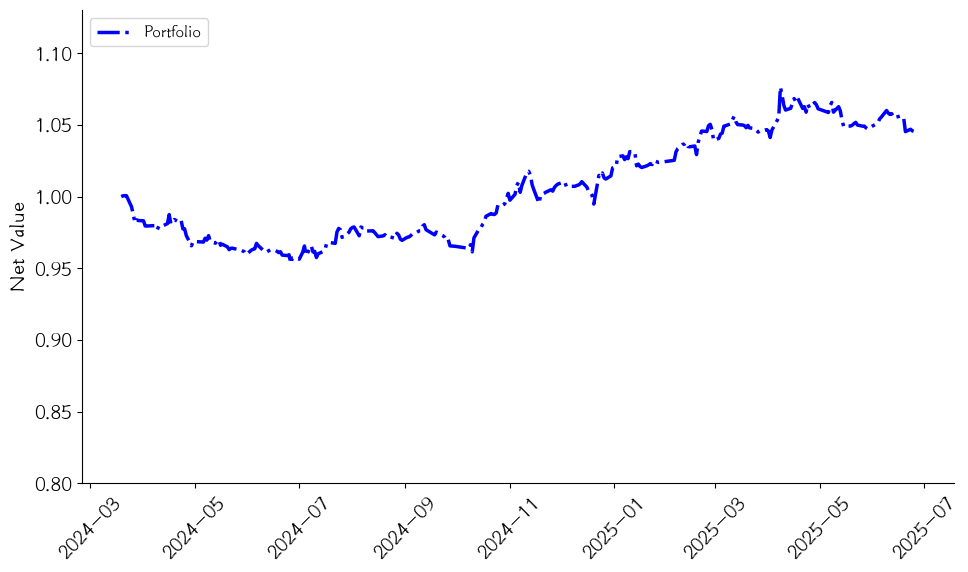

In [59]:
backtest_df_total = combined_df.copy()
backtest_df_total.set_index("date",inplace = True)
nv_cols_total = [c for c in backtest_df_total.columns if c.endswith('_nv')]
ret_total = backtest_df_total[nv_cols_total].pct_change()
vol_total = ret_total.rolling(window=60).std()
inv_vol_total = 1/vol_total
weights_total = inv_vol_total.div(inv_vol_total.sum(axis=1),axis=0)
# 为避免未来函数（look-ahead），所有权重往后移一格
weights_total = weights_total.shift(1).dropna()
port_ret_total = (weights_total * ret_total.loc[weights_total.index]).sum(axis=1)
backtest_df_total['portfolio_nv'] = (1 + port_ret_total).cumprod()
backtest_df_total.dropna(subset=['portfolio_nv'], inplace=True)
backtest_df_total = backtest_df_total.div(backtest_df_total.iloc[0])


In [60]:
plot_df_total = backtest_df_total.copy().reset_index()
plot_df_total['date'] = pd.to_datetime(plot_df_total['date'])

plt.figure(figsize=(10,6))

plt.plot(plot_df_total['date'], plot_df_total['portfolio_nv'], label='Portfolio', color='blue', linewidth=2.5, linestyle='-.')

# 图例
plt.legend(loc='upper left', fontsize=12)

# 坐标轴范围
ymax = plot_df_total[['portfolio_nv']].max().max()
plt.ylim(0.8, ymax * 1.05)

# 样式设置
plt.xticks(rotation=45)
plt.grid(False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# 标题和坐标轴
plt.ylabel('Net Value')
plt.tight_layout()
plt.show()


{'ann_r': np.float64(0.03827731058876519), 'sharpe': 0.6754401608214329, 'sortino': 1.0523916492220557, 'maxdd_pct': -471.9595546159871, 'maxdd_date': Timestamp('2024-06-25 00:00:00'), 'calmar': np.float64(0.7962432982530019), 'ulcer_index': 121.6478263037943, 'upi': -3.3349606423787455}


In [ ]:
from pybroker.eval import (
    sharpe_ratio, sortino_ratio, max_drawdown_percent,
    calmar_ratio, ulcer_index, upi,
)

nav = backtest_df_total['portfolio_nv']  # pandas.Series，索引为时间戳；值为净值
returns = nav.pct_change().dropna().values  # numpy.ndarray

sharpe = sharpe_ratio(returns, obs=252)
sortino = sortino_ratio(returns, obs=252)
maxdd_pct, maxdd_idx = max_drawdown_percent(returns)
calmar = calmar_ratio(returns,bars_per_year=252)
ui = ulcer_index(returns)
upi_val = upi(returns)
ann_r=returns.mean()*252

print(dict(
    ann_r = ann_r,
    sharpe=sharpe,
    sortino=sortino,
    maxdd_pct=maxdd_pct * 100,
    maxdd_date=nav.index[maxdd_idx],
    calmar=calmar,
    ulcer_index=ui,
    upi=upi_val
))


## 等权重

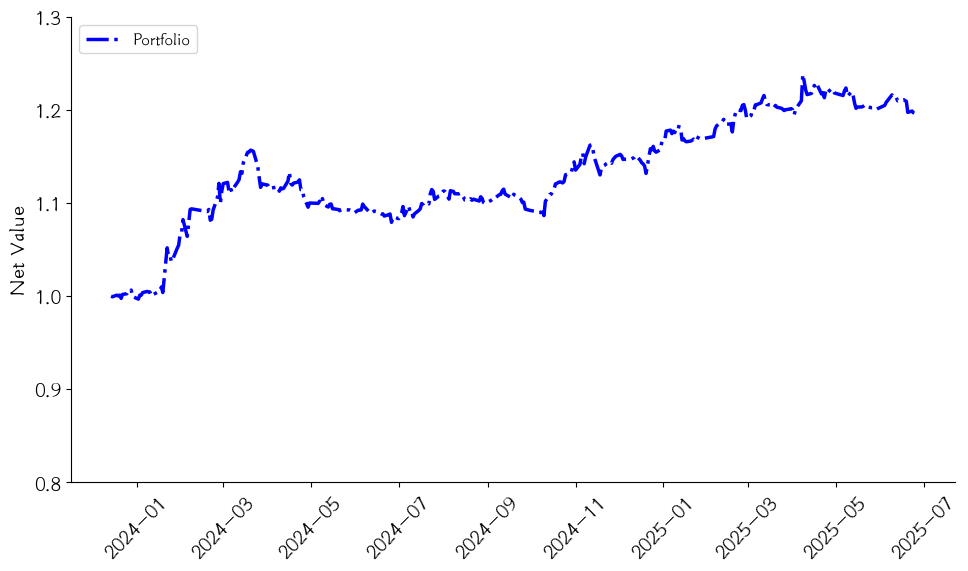

In [68]:
# backtest_df_equal= combined_df[['date','IMIC_nv','ICIF_nv','IFIH_nv']].copy()
backtest_df_equal= combined_df.copy()
backtest_df_equal.set_index("date", inplace=True)

# 获取净值列
nv_cols_equal = [c for c in backtest_df_equal.columns if c.endswith('_nv')]

# 计算收益率
ret_equal = backtest_df_equal[nv_cols_equal].pct_change()

# 创建等权重矩阵
# 每个时间点的权重都相等：1/N
num_assets = len(nv_cols_equal)
equal_weights = pd.DataFrame(
    1 / num_assets,
    index=ret_equal.index,
    columns=nv_cols_equal
)
weights_equal = equal_weights.dropna()

# 计算投资组合收益率
port_ret_equal = (weights_equal * ret_equal.loc[weights_equal.index]).sum(axis=1)

# 计算投资组合净值
backtest_df_equal['portfolio_nv'] = (1 + port_ret_equal).cumprod()

# 删除缺失值并归一化（第一天为 1）
backtest_df_equal.dropna(subset=['portfolio_nv'], inplace=True)
backtest_df_equal = backtest_df_equal.div(backtest_df_equal.iloc[0])


In [69]:
plot_df_equal = backtest_df_equal.copy().reset_index()
plot_df_equal['date'] = pd.to_datetime(plot_df_equal['date'])

plt.figure(figsize=(10,6))

# plt.plot(plot_df_equal['date'], plot_df_equal['ICIF_nv'], label='IC_IF', color='red', linewidth=2.5)
# plt.plot(plot_df_equal['date'], plot_df_equal['IFIH_nv'], label='IF_IH', color='gray', linewidth=2.5)
# plt.plot(plot_df_equal['date'], plot_df_equal['IMIC_nv'], label='IM_IH', color='pink', linewidth=2.5, linestyle='--')
plt.plot(plot_df_equal['date'], plot_df_equal['portfolio_nv'], label='Portfolio', color='blue', linewidth=2.5, linestyle='-.')

# 图例
plt.legend(loc='upper left', fontsize=12)

# 坐标轴范围
ymax = plot_df_equal[['portfolio_nv']].max().max()
plt.ylim(0.8, ymax * 1.05)

# 样式设置
plt.xticks(rotation=45)
plt.grid(False)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# 标题和坐标轴
plt.ylabel('Net Value')
plt.tight_layout()
plt.show()


{'ann_r': np.float64(0.12692399410965396), 'sharpe': 1.4385262665668872, 'sortino': 2.2841647306312742, 'maxdd_pct': -670.8936590804892, 'maxdd_date': Timestamp('2024-06-25 00:00:00'), 'calmar': np.float64(1.84400622694583), 'ulcer_index': 119.22393160108298, 'upi': -2.2754348164367535}


In [ ]:
from pybroker.eval import (
    sharpe_ratio, sortino_ratio, max_drawdown_percent,
    calmar_ratio, ulcer_index, upi,
)

nav = backtest_df_equal['portfolio_nv']  # pandas.Series，索引为时间戳；值为净值
returns = nav.pct_change().dropna().values  # numpy.ndarray

sharpe = sharpe_ratio(returns, obs=252)
sortino = sortino_ratio(returns, obs=252)
maxdd_pct, maxdd_idx = max_drawdown_percent(returns)
calmar = calmar_ratio(returns,bars_per_year=252)
ui = ulcer_index(returns)
upi_val = upi(returns)
ann_r=returns.mean()*252

print(dict(
    ann_r = ann_r,
    sharpe=sharpe,
    sortino=sortino,
    maxdd_pct=maxdd_pct * 100,
    maxdd_date=nav.index[maxdd_idx],
    calmar=calmar,
    ulcer_index=ui,
    upi=upi_val
))


# 因子代码调试

In [1]:
import  pandas as pd
index_data = pd.read_csv("/Users/yaoyuyang/Desktop/Code/daily_futures_arbitrary_strategy/data/raw/index_nv_data.csv")

In [2]:
from data_utils import generate_ohlc
import numpy as np
import  talib
data = generate_ohlc(index_data,'IMIC')

In [22]:
#资金流量指数
def mfi_signal(price: pd.DataFrame,
               timeperiod: int = 14,
               threshold: float = 20,
               volume_method: str="sub") -> pd.Series:
    """
    资金流量指数（MFI）信号：
    - MFI > 100 - threshold → 看空（-1）
    - MFI < threshold → 看多（+1）
    - 其他情况 → 观望（0）

    参数
    ----
    price : pd.DataFrame, 必须包含 "high","low","close","volume"
    timeperiod : MFI 计算窗口
    threshold : 超买/超卖阈值，默认 20

    返回
    ----
    pd.Series: 信号（1=多, -1=空, 0=观望）
    """
    if not {"high", "low", "close", f"volume_{volume_method}"}.issubset(price.columns):
        raise ValueError(f"price 必须包含列：'high','low','close','volume_{volume_method}'")
    if not price.index.is_monotonic_increasing:
        price = price.sort_index()

    high = price["high"].astype(float)
    low = price["low"].astype(float)
    close = price["close"].astype(float)
    volume = price[f"volume_{volume_method}"].astype(float)

    # 计算 MFI
    mfi = talib.MFI(high, low, close, volume, timeperiod=timeperiod)

    # 初始化信号
    signal = pd.Series(0, index=price.index, dtype=int)
    signal[mfi > 100 - threshold] = -1  # 超买 → 做空
    signal[mfi < threshold] = 1         # 超卖 → 做多

    return signal

signal = mfi_signal(data)